# Systems Identification Model Fitting

Fit a Systems Identification model off based off of this [specification](https://hackmd.io/w-vfdZIMTDKwdEupeS3qxQ) and [spec](https://hackmd.io/XVaejEw-QaCghV1Tkv3eVQ) with data obtained in [data_acquisition.ipynb](data/data_acquisition.ipynb).

#### Process changes and decision points
* Create differenced linear regressor model for refining data formatting
* Fit VAR model off of differenced states with Yeo-Johnson power transformation
* Implemented coordinate transformations 
* Created inverse transformations
* Fit one step forward VAR model that takes the difference between local arbitrager values and observed values and forcasts the errors within the coordinate transformation state.
* Fit VARMAX model with exogenous signal - error between redemption price and rai market price - retrain after every timestep 
* Compare VARMAX vs VAR model
* Refactor to functions for deployment



## Analyze and Prepare Data

In [463]:
# import libraries
import pandas as pd
import numpy as np
from scipy import stats
import math


import statsmodels.api as sm
from statsmodels.tsa.api import VAR, VARMAX
#from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


states = pd.read_csv('states.csv')
del states['Unnamed: 0']
states.head()

,marketPriceEth,marketPriceUsd,block_number,debtAvailableToSettle,globalDebt,globalDebtCeiling,systemSurplus,totalActiveSafeCount,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice,EthInUniswap,RaiInUniswap,RaiDrawnFromSAFEs,collateral,debt,ETH Price (OSM)
0,0.000858,3.051840,12388143.0,0.0,2.632464e+07,1.157921e+32,230002.364951,583.0,0.978704,0.999998,0.99998,3.005443,11977.048864,1.389236e+07,2.601571e+07,1249.4226,293469.366076,3521.749280
1,0.000858,3.051840,12387897.0,0.0,2.632464e+07,1.157921e+32,230002.364951,583.0,0.978704,0.999998,0.99998,3.005450,12025.302340,1.383645e+07,2.601571e+07,1249.4226,293469.366076,3484.967617
2,0.000869,3.060763,12387633.0,0.0,2.629462e+07,1.157921e+32,229927.716817,583.0,0.978704,0.999998,0.99998,3.005465,12033.680708,1.382679e+07,2.598571e+07,1249.4226,293469.366076,3509.940000
3,0.000870,3.051668,12387345.0,0.0,2.629462e+07,1.157921e+32,229927.716817,583.0,0.978704,0.999998,0.99998,3.005465,12033.680708,1.382679e+07,2.598571e+07,1249.4226,293469.366076,3438.463957
4,0.000875,3.043224,12387095.0,0.0,2.629407e+07,1.157921e+32,229903.041060,583.0,0.978704,0.999998,0.99998,3.005472,12080.165571,1.377424e+07,2.598521e+07,1249.4226,293469.366076,3464.125574


In [464]:
# save block numbers
blockNumbers = states.block_number.values

In [465]:
states['RedemptionPriceinEth'] = states['RedemptionPrice'] / states['ETH Price (OSM)']

In [466]:
states['RedemptionPriceError'] = states['RedemptionPrice'] - states['marketPriceUsd']

### Systems identification steps:
1. Calculate optimal state from APT model

2. Perform a coordinate transformation of data 

3. Difference the local coordiante from the observed to get error

4. Train VARMAX the errors + exogenous signal[s]

5. One step forecast

5. Convert forecasted values back from coordinate system 

6. Add forecasted values to previous state to get new state 


### Mapping of specification states to data

#### Initial vector 
The quantity state variables of the system are as value, mathematical notation, and Graph and Big Query field names from [data_acquisition.ipynb](data/data_acquisition.ipynb).
* ETH in collateral = $Q$ = collateral 
* ETH in Uniswap = $R_{ETH}$ = EthInUniswap
* RAI in Uniswap = $R_{RAI}$ = RaiInUniswap 
* RAI drawn from SAFEs = $D$ = RaiDrawnFromSAFEs


<!-- (GlobalDebt won't equal total supply (create graphics around?)) -->

The metric state variables of the system are:

* Market Price of RAI in ETH = $p_{E/R} > 0$   = marketPriceEth
* Market Price of RAI in USD =  $p_{U/R} > 0$ =  marketPriceUsd
* Market Price of ETH in USD = $p_{U/E} > 0$ = ETH Price (OSM)

The metric control variables of the system are:

* Redemption Price of RAI in USD = $p^r_{U/R} > 0$ = RedemptionPrice
* Redemption Price of RAI in ETH = $p^r_{E/R} > 0$ = RedemptionPriceinEth 

The system parameters are:
* Liquidation Ratio = $\bar{L} > 0$ = 1.45
* SAFE Debt Ceiling = $\bar{D} > 0$ = globalDebtCeiling
* Uniswap Fee =  $\phi_U \in (0,1)$  = 0.003 
* Gas Costs = $\bar{C}_{gas} \geq 0$ = 100e-9, # 100 gwei

The aggregate flow variables are:
* Collateral added or removed =  $q \in \mathbb{R}$ (ETH)
* SAFE Debt drawn or repaid = $d \in \mathbb{R}$   (RAI)
* Uniswap RAI bought or sold = $r \in \mathbb{R}$   (RAI)
* Uniswap ETH bought or sold = $z \in \mathbb{R}$   (ETH)


### Model Formulation


There is an admissible action set of vectors:
(Graph values)
* ETH in collateral = $Q$ = collateral
* ETH in Uniswap = $R_{ETH}$ reserve1
* RAI in Uniswap = $R_{RAI}$ = reserve0 
* RAI drawn from SAFEs = $D$ = erc20CoinTotalSupply



Action vector: $\vec{u} = (\Delta Q, \Delta R_{ETH}, \Delta R_{RAI}, \Delta D)$

Admissible action set: $\vec{u} \in \mathcal{U}$

Optimal Action Vector: $\vec{u^*} = (Q^*, R_{ETH}^*, \Delta R_{RAI}^*, \Delta D^*)$


In [467]:
# constants
params = {
    'liquidation_ratio': Lbar,
    'debt_ceiling': 1e9,
    'uniswap_fee': 0.003,
    'arbitrageur_considers_liquidation_ratio': True,
}


## Arbtrageur data

In [468]:
def get_aggregated_arbitrageur_decision(params, state):

    # This Boolean indicates whether or not the arbitrageur is rationally considering 
    # borrowing to the liquidation ratio limit. If TRUE, arbitrage opportunities are less
    # frequent when RAI is expensive and more frequent when RAI is cheap. If FALSE, only 
    # the difference in market and redemption prices (net of Uniswap fee) matters for trading, 
    # which may conform more to individual trader expectations and behavior.
    consider_liquidation_ratio = params['arbitrageur_considers_liquidation_ratio']
    
    # These are the states of the SAFE balances in aggregate & its fixed parameters
    total_borrowed = state['SAFE_Debt'] # D
    total_collateral = state['SAFE_Collateral'] # Q
    liquidation_ratio = params['liquidation_ratio']
    debt_ceiling = params['debt_ceiling']


    # These are the states of the Uniswap secondary market balances and its fee
    RAI_balance = state['RAI_balance'] # R_Rai
    ETH_balance = state['ETH_balance'] # R_Eth
    uniswap_fee = params['uniswap_fee']

    # These are the prices of RAI in USD/RAI for SAFE redemption and the market price oracle, resp.
    redemption_price = state['target_price'] # $p^r_{U/R}
    market_price = state['market_price'] # p_{U/R} > 0
    
    # This is the price of ETH in USD/ETH
    eth_price = state['eth_price'] # p_{U/E}

        
    # These functions define the optimal borrowing/repayment decisions of the aggregated arbitrageur
    def g1(RAI_balance, ETH_balance, uniswap_fee, liquidation_ratio, redemption_price):
        return ((eth_price * RAI_balance * ETH_balance * (1 - uniswap_fee)) / (liquidation_ratio * redemption_price)) ** 0.5

    def g2(RAI_balance, ETH_balance, uniswap_fee, liquidation_ratio, redemption_price):
        return (RAI_balance * ETH_balance * (1 - uniswap_fee) * liquidation_ratio * (redemption_price / eth_price)) ** 0.5

    # This Boolean resolves to TRUE if the agg. arb. acts this timestep when RAI is expensive 
    # on the secondary market
    expensive_RAI_on_secondary_market = \
        redemption_price < ((1 - uniswap_fee) / liquidation_ratio) * market_price  \
        if consider_liquidation_ratio \
        else redemption_price < (1 - uniswap_fee) * market_price
        
    # This Boolean resolves to TRUE if the agg. arb. acts this timestep when RAI is cheap 
    # on the secondary market
    cheap_RAI_on_secondary_market = \
        redemption_price > (1 / ((1 - uniswap_fee) * liquidation_ratio)) * market_price  \
        if consider_liquidation_ratio \
        else redemption_price > (1 / (1 - uniswap_fee)) * market_price

    if expensive_RAI_on_secondary_market:
        '''
        Expensive RAI on Uni:
        (put ETH from pocket into additional collateral in SAFE)
        draw RAI from SAFE -> Uni
        ETH from Uni -> into pocket
        '''

        _g1 = g1(RAI_balance, ETH_balance, uniswap_fee,
                 liquidation_ratio, redemption_price)
        d = (_g1 - RAI_balance) / (1 - uniswap_fee) # should be \geq 0
        q = ((liquidation_ratio * redemption_price) /
                     eth_price) * (total_borrowed + d) - total_collateral # should be \geq 0
        z = -(ETH_balance * d * (1 - uniswap_fee)) / \
            (RAI_balance + d * (1 - uniswap_fee)) # should be leq 0
        r = d # should be \geq 0
        
    elif cheap_RAI_on_secondary_market:
        '''
        Cheap RAI on Uni:
        ETH out of pocket -> Uni
        RAI from UNI -> SAFE to wipe debt
        (and collect collateral ETH from SAFE into pocket)
        '''

        _g2 = g2(RAI_balance, ETH_balance, uniswap_fee,
                 liquidation_ratio, redemption_price)
        z = (_g2 - ETH_balance) / (1 - uniswap_fee) # should be \geq 0
        r = -(RAI_balance * z * (1 - uniswap_fee)) / \
            (ETH_balance + z * (1 - uniswap_fee)) # should be \leq 0
        d = r # should be \leq 0
        q = ((liquidation_ratio * redemption_price /
             eth_price) * (total_borrowed + d) - total_collateral) # should be \leq 0
    else:
        pass

    return {
        'q' : q,
        'd' : d,
        'r' : r,
        'z' : z
    }

In [469]:
state_subset = states[['marketPriceUsd','RedemptionPrice','ETH Price (OSM)','collateral',
                       'EthInUniswap','RaiInUniswap','RaiDrawnFromSAFEs']]

state_subset.columns = ['market_price','target_price','eth_price','SAFE_Collateral',
                       'ETH_balance','RAI_balance','SAFE_Debt']

In [470]:
values = []
values.append(get_aggregated_arbitrageur_decision(params,state_subset.loc[0]))

In [471]:
values = []

for i in range(0,len(state_subset)):
    values.append(get_aggregated_arbitrageur_decision(params,state_subset.loc[i]))
    
local = pd.DataFrame(values)
local.columns = ['Q','D','Rrai','Reth']
local.head()

,Q,D,Rrai,Reth
0,28122.869039,-2.279045e+06,-2.279045e+06,2357.497660
1,28426.718797,-2.284020e+06,-2.284020e+06,2384.664437
2,28241.725552,-2.233082e+06,-2.233082e+06,2324.799929
3,28704.381800,-2.351735e+06,-2.351735e+06,2473.643064
4,28602.135401,-2.256182e+06,-2.256182e+06,2373.409556


## Coordinate Transformations TODO: add contraints

1. $\alpha := \frac{d}{\bar{D}}$

$ C_0 := \frac{p^r_{U/R}}{p_{U/E}}\bar{L} > 0$

$ C_0 D - Q =: C_1.$

2. $\beta := \frac{q - C_0 d}{C_1}$

3. $\gamma := \frac{r}{R_{RAI}}$

4. $\delta := \frac{z}{R_{ETH}}$


## Inverse Transformations

1. $d^* = \alpha * \bar{D}$

2. $q^* = C_0 * \bar{D} * \alpha + C_1 * \beta$

3. $r^* = \gamma * {R_{RAI}}$

4. $z^* = \delta * {R_{ETH}}$


In [472]:
def coordinate_transformations(params,df,Q,R_eth,R_rai,D,RedemptionPrice,EthPrice ):
    '''
    Description:
    Function that takes in pandas dataframe and the names of columns
    
    Parameters:
    df: pandas dataframe containing states information
    Q: dataframe column name
    R_eth: dataframe column name
    R_rai: dataframe column name
    D: dataframe column name
    RedemptionPrice: dataframe column name
    EthPrice: dataframe column name

    Returns: Pandas dataframe with alpha, beta, gamma, delta transformed values
    
    Example:
    
    coordinate_transformations(params,states,'collateral','EthInUniswap','RaiInUniswap',
                           'RaiDrawnFromSAFEs','RedemptionPrice','ETH Price (OSM)')[['alpha','beta','gamma','delta']]
    '''
    
    d = df[D].diff()
    d.fillna(0,inplace=True)
    df['d'] = d

    df['alpha'] = df['d'] / params['debt_ceiling']

    df['C_o'] = (df[RedemptionPrice]/states[EthPrice]) * params['liquidation_ratio']

    q = df[Q].diff()
    q.fillna(0,inplace=True)
    df['q'] = q


    df['C_1'] = (df['C_o'] * df[D]) - df[Q]

    df['beta'] = (df['q'] - (df['C_o']*df['d']))/ df['C_1']


    r = df[R_rai].diff()
    r.fillna(0,inplace=True)
    df['r'] = r

    df['gamma'] = df['r']/df[R_rai]

    z = df[R_eth].diff()
    z.fillna(0,inplace=True)
    df['z'] = z

    df['delta'] = df['z']/df[R_eth]
    
    return df

In [473]:
transformed = coordinate_transformations(params,states,'collateral','EthInUniswap','RaiInUniswap',
                           'RaiDrawnFromSAFEs','RedemptionPrice','ETH Price (OSM)')[['alpha','beta','gamma','delta']]

transformed

,alpha,beta,gamma,delta
0,0.000000e+00,0.000000,0.000000,0.000000
1,0.000000e+00,0.000000,-0.004041,0.004013
2,-3.000000e-05,0.001201,-0.000699,0.000696
3,0.000000e+00,0.000000,0.000000,0.000000
4,-5.000000e-07,0.000020,-0.003815,0.003848
...,...,...,...,...
1942,-1.646075e-06,0.108212,0.249397,-0.333334
1943,0.000000e+00,-0.000000,0.000000,0.000000
1944,0.000000e+00,-0.000000,0.000000,0.000000
1945,0.000000e+00,-0.000000,0.000000,0.000000


In [474]:
q_local = local['Q'].diff() 
q_local.fillna(0,inplace=True)
local['q'] = q_local
d_local = local['D'].diff()
d_local.fillna(0,inplace=True)
local['d'] = d_local

local['alpha'] = local['d'] / params['debt_ceiling']

local['C_1'] = (states['C_o'] * local['D']) - local['Q']

local['beta'] = (local['q'] - (states['C_o']*local['d']))/ local['C_1']


r_local = local['Rrai'].diff()
r_local.fillna(0,inplace=True)
local['r'] = r_local

local['gamma'] = local['r']/local['Rrai']


z_local = local['Reth'].diff()
z_local.fillna(0,inplace=True)
local['z_local'] = z_local

local['delta'] = local['z_local']/local['Reth']

In [475]:
alpha_diff = transformed['alpha'] - local['alpha']
beta_diff = transformed['beta'] - local['beta']
gamma_diff = transformed['gamma'] - local['gamma']
delta_diff = transformed['delta'] - local['delta']


e_u = pd.DataFrame(alpha_diff)
e_u['beta'] = beta_diff
e_u['gamma'] = gamma_diff
e_u['delta'] = delta_diff

e_u.head()

,alpha,beta,gamma,delta
0,0.000000,0.000000,0.000000,0.000000
1,0.000005,0.009912,-0.006219,-0.007380
2,-0.000081,-0.006803,0.022112,0.026447
3,0.000119,0.019348,-0.050454,-0.060172
4,-0.000096,-0.007055,0.038537,0.046080


In [476]:
e_u = e_u.astype(float)

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'delta'}>]], dtype=object)

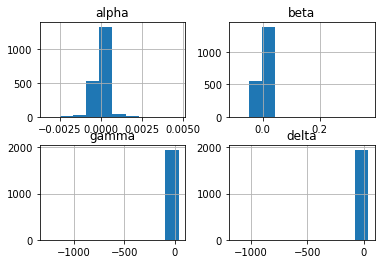

In [477]:
e_u.hist()

## Create model

In [478]:
# split data between train and test
split_point = int(len(e_u) * .8)
train = e_u.iloc[0:split_point]
test = e_u.iloc[split_point:]


states_train = states.iloc[0:split_point]
states_test = states.iloc[split_point:]

<!-- Potential alternative transformations are as follows:

* sin
* log of the Yeo-Johnson

Both of which provide a better fit than the Yeo-Johnson (as seen below).


For the rest of this notebook, we will implement the model training, forecasting, and evaluation process which will allow us to iterate over different transformations until we find one that fits our use case the best. -->

### Autogressive lag selection

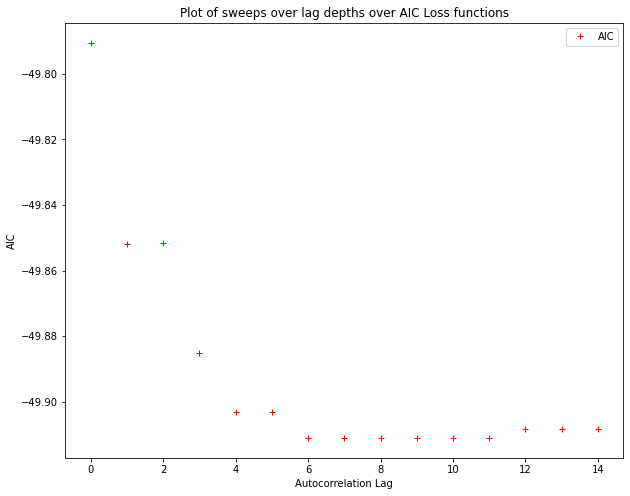

In [479]:
aic = []
for i in range(1,16):
    model = VAR(train)
    results = model.fit(i,ic='aic')
    aic.append(results.aic)
    
    
plt.figure(figsize=(10, 8))
plt.plot(aic, 'r+')
plt.legend(['AIC'])
plt.xlabel('Autocorrelation Lag')
plt.ylabel('AIC')
plt.title('Plot of sweeps over lag depths over AIC Loss functions')
plt.show()

Given a set of candidate models for the data, **the preferred model is the one with the minimum AIC value, the sign of the data does not matter**. AIC optimizes for goodness of fit but also includes a penalty for each additional parameter, which discourages overfitting. In our case, this appears that a lag of ***7*** is optimal.


For a VARMAX model, which we have decided to use, an order of 1 is selected.

In [480]:
# aic = []
# for i in range(1,16):
#     model = VARMAX(endog=train.values,exog=states_train['RedemptionPriceError'].values,initialization='approximate_diffuse')
#     results = model.fit(order=(i,0))
#     aic.append(results.aic)
    
    
# plt.figure(figsize=(10, 8))
# plt.plot(aic, 'r+')
# plt.legend(['AIC'])
# plt.xlabel('Autocorrelation Lag')
# plt.ylabel('AIC')
# plt.title('Plot of sweeps over lag depths over AIC Loss functions')
# plt.show()

In [481]:
# instantiate the var model object from statsmodels
model = VARMAX(endog=train.values,exog=states_train['RedemptionPriceError'].values,
               initialization='approximate_diffuse',measurement_error=True)

# fit model with determined lag values
results = model.fit(order=(1,0))
results.summary()

Dep. Variable:,"['y1', 'y2', 'y3', 'y4']",No. Observations:,1557
Model:,VARX(1),Log Likelihood,24221.368
,+ intercept,AIC,-48366.736
,+ measurement error,BIC,-48163.416
Date:,"Thu, 20 May 2021",HQIC,-48291.133
Time:,13:09:12,,
Sample:,0,,
,- 1557,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.02, 2.18, 40.03, 25.58",Jarque-Bera (JB):,"146732.73, 1061.88, 4704.94, 4102.24"
Prob(Q):,"0.88, 0.14, 0.00, 0.00",Prob(JB):,"0.00, 0.00, 0.00, 0.00"


In [482]:
Y_pred = results.forecast(exog=states_test['RedemptionPriceError'].values[0])

In [483]:
Y_test = test[:1]

In [484]:
Y_test

,alpha,beta,gamma,delta
1557,-0.000076,0.002263,0.005782,0.006588


In [485]:
Y_pred[0]

array([ 0.00021718,  0.00917545, -0.02992443, -0.0372027 ])

<!-- ### Univarate model performance validation -->

In [486]:
Y_pred[:,3]

array([-0.0372027])

In [487]:
"{:.10}".format(float(Y_test['delta']))

'0.00658803169'

## New states

## Inverse Transformations

1. $d^* = \alpha * \bar{D}$

2. $q^* = C_0 * \bar{D} * \alpha + C_1 * \beta$.

3. $r^* = \gamma * {R_{RAI}}$

4. $z^* = \delta * {R_{ETH}}$

In [488]:
# change
Y_pred

array([[ 0.00021718,  0.00917545, -0.02992443, -0.0372027 ]])

In [489]:
previous_state = states.iloc[train.index[-1]]

In [490]:
params

{'liquidation_ratio': 1.45,
 'debt_ceiling': 1000000000.0,
 'uniswap_fee': 0.003,
 'arbitrageur_considers_liquidation_ratio': True}

In [491]:
d_star = Y_pred[:,0] * params['debt_ceiling']
d_star

array([217175.30225435])

In [492]:
q_star = previous_state['C_o'] * params['debt_ceiling'] * Y_pred[:,0] + previous_state['C_1'] * Y_pred[:,1]
q_star

array([1378.28103242])

In [493]:
r_star = Y_pred[:,2] * previous_state['gamma'] * previous_state['RaiInUniswap']
r_star

array([-2105.65246851])

In [494]:
z_star = Y_pred[:,3] * previous_state['delta'] * previous_state['EthInUniswap']
z_star

array([-5.73879159])

In [495]:
last_state = states.iloc[train.index[-1]][['collateral','EthInUniswap','RaiInUniswap','RaiDrawnFromSAFEs']].to_dict()
new_state = pd.DataFrame(last_state,index=[0]) 
new_state['Q'] = new_state['collateral'] + q_star
new_state['D'] = new_state['RaiDrawnFromSAFEs'] + d_star
new_state['R_Eth'] = new_state['EthInUniswap'] + r_star
new_state['R_Rai'] = new_state['RaiInUniswap'] + z_star
print('Previous State:')
print(pd.DataFrame(last_state,index=[0]))
print('\n')
print('New State:')
new_state[['Q','R_Eth','R_Rai','D']]

Previous State:
   collateral  EthInUniswap  RaiInUniswap  RaiDrawnFromSAFEs
0   6112.1732    61661.2124  2.971980e+07       3.373423e+07


New State:


,Q,R_Eth,R_Rai,D
0,7490.454232,59555.559932,2.971980e+07,3.395140e+07


## Deployment info
"Hey Andrew, it will be encapsulated by the last PSUB (not implemented yet)
we will need to implement a cadCAD policy that returns a dict with the rai_reserve, eth_reserve, rai_debt and eth_locked keys
https://github.com/BlockScience/reflexer-digital-twin/tree/master/rai_digital_twin/models/digital_twin_v1/model

The definition of the classes are on the end of https://github.com/BlockScience/reflexer-digital-twin/blob/master/rai_digital_twin/types.py

we'll be adding a UserActionParams class with all the parameters that the model requires

"
